In [34]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

In [37]:
#Plotting
def plot_clas_g1_data():
    # Define the directory and file names
    directory = r"C:\Users\castl\Desktop\Internship stuff\Data_Lionel\Data_Lionel\CLAS_data\3...HEPData-ins621221-v1-csv"
    files = [f'Table{i}.csv' for i in range(3, 8)]
    
    #Style
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    markers = ['o', 's', '^', 'v', 'D', '<', '>', 'p']
    
    #Create figure
    plt.figure(figsize=(12, 8))
    
    datasets_loaded = 0
    
    #Define Q² ranges for each table (manually added for funsies)
    q2_values = {
        'Table1.csv': '__',
        'Table2.csv': '__', 
        'Table3.csv': '0.15-0.27',
        'Table4.csv': '0.27-0.5',
        'Table5.csv': '0.5-0.74',
        'Table6.csv': '0.74-1.1',
        'Table7.csv': '1.1-1.64',
        'Table8.csv': '4.52'
    }
    
    for i, filename in enumerate(files):
        filepath = os.path.join(directory, filename)
        
        if not os.path.exists(filepath):
            print(f"Warning: {filename} not found, skipping...")
            continue
            
        try:
            df = None
            q2_range = q2_values.get(filename, "Unknown")
            
            if df is None:
                try:
                    with open(filepath, 'r', encoding='utf-8') as file:
                        lines = file.readlines()
                    
                    # Extract Q² info and find data start
                    data_lines = []
                    header_found = False
                    
                    for line in lines:
                        line = line.strip()
                        if line.startswith('#'):
                            if 'Q**2' in line or 'Q²' in line or 'Q2' in line:
                                parts = line.split()
                                for j, part in enumerate(parts):
                                    if 'GeV' in part and j > 0:
                                        #Try to extract the numeric value before 'GeV'
                                        try:
                                            q2_val = float(parts[j-1])
                                            q2_range = f"{q2_val:.3f}"
                                            break
                                        except:
                                            continue
                        elif line and not header_found:
                            data_lines.append(line)
                            header_found = True
                        elif line and header_found:
                            #Data lines
                            data_lines.append(line)
                    
                    #Create DataFrame from lines
                    if data_lines:
                        from io import StringIO
                        df = pd.read_csv(StringIO('\n'.join(data_lines)), 
                                       skipinitialspace=True,
                                       on_bad_lines='skip')
                        print(f"Approach 2 successful for {filename}")
                except Exception as e:
                    print(f"Approach 2 failed for {filename}: {e}")
            
            #Clean column names (remove whitespace)
            df.columns = df.columns.str.strip()
            
            #Debug
            print(f"Columns in {filename}: {list(df.columns)}")
            print(f"Shape: {df.shape}")
            if len(df) > 0:
                print(f"First row: {df.iloc[0].to_dict()}")
            print("-" * 50)
            
            #Check if we have the expected columns
            if 'X' not in df.columns or 'G1' not in df.columns:
                print(f"Warning: Expected columns 'X' and 'G1' not found in {filename}")
                print(f"Available columns: {list(df.columns)}")
                continue
            
            #Filter out invalid rows
            df=df.dropna(subset=['X', 'G1'])
            df=df[pd.to_numeric(df['X'], errors='coerce').notna()]
            df=df[pd.to_numeric(df['G1'], errors='coerce').notna()]
            
            #Convert to numeric
            df['X']=pd.to_numeric(df['X'])
            df['G1']=pd.to_numeric(df['G1'])
            
            #Error
            stat_pos=pd.to_numeric(df.get('stat +', 0), errors='coerce').fillna(0)
            stat_neg=pd.to_numeric(df.get('stat -', 0), errors='coerce').fillna(0)

            #Calculate total errors (quadrature sum)
            total_error_pos=np.sqrt(stat_pos**2)
            total_error_neg=np.sqrt(stat_neg**2)
            
            #Error Bars
            yerr=[total_error_neg.abs(), total_error_pos]
            
            #Sort by X values
            df=df.sort_values('X')
            
            #Plot
            plt.errorbar(df['X'], df['G1'], 
                        yerr=yerr,
                        fmt=markers[i % len(markers)], 
                        color=colors[i % len(colors)],
                        markersize=5,
                        capsize=2,
                        capthick=1,
                        linewidth=1.5,
                        label=f'Q² = {q2_range}',
                        alpha=0.8)
            
            datasets_loaded += 1
            print(f"Loaded {filename}: {len(df)} data points")
            
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue
    
    #Add zero reference line
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    #Formatting
    plt.xlabel('x', fontsize=14)
    plt.ylabel('G1', fontsize=14)
    plt.title('CLAS: e + p → e + X scattering, G1', fontsize=16, pad=20)
    plt.grid(True, alpha=0.3, linewidth=0.5)
    legend=plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', 
                       frameon=True, fancybox=True, shadow=False,
                       fontsize=11, markerscale=1.2)
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_facecolor('white')
    
    #Set axis limits
    plt.xlim(0.05, 0.9)
    
    #Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    #Add subtle styling improvements
    ax=plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    print(f"\nSuccessfully loaded {datasets_loaded} datasets")
    
    plt.show()

Approach 2 successful for Table3.csv
Columns in Table3.csv: ['X', 'G1', 'stat +', 'stat -', 'sys +', 'sys -']
Shape: (26, 6)
First row: {'X': 0.05356, 'G1': 0.00856, 'stat +': 0.08823, 'stat -': -0.08823, 'sys +': 0.02336, 'sys -': -0.02336}
--------------------------------------------------
Loaded Table3.csv: 26 data points
Approach 2 successful for Table4.csv
Columns in Table4.csv: ['X', 'G1', 'stat +', 'stat -', 'sys +', 'sys -']
Shape: (38, 6)
First row: {'X': 0.06073, 'G1': 0.15266, 'stat +': 0.06714, 'stat -': -0.06714, 'sys +': 0.02575, 'sys -': -0.02575}
--------------------------------------------------
Loaded Table4.csv: 38 data points
Approach 2 successful for Table5.csv
Columns in Table5.csv: ['X', 'G1', 'stat +', 'stat -', 'sys +', 'sys -']
Shape: (36, 6)
First row: {'X': 0.10133, 'G1': 0.22295, 'stat +': 0.07427, 'stat -': -0.07427, 'sys +': 0.02508, 'sys -': -0.02508}
--------------------------------------------------
Loaded Table5.csv: 36 data points
Approach 2 successf

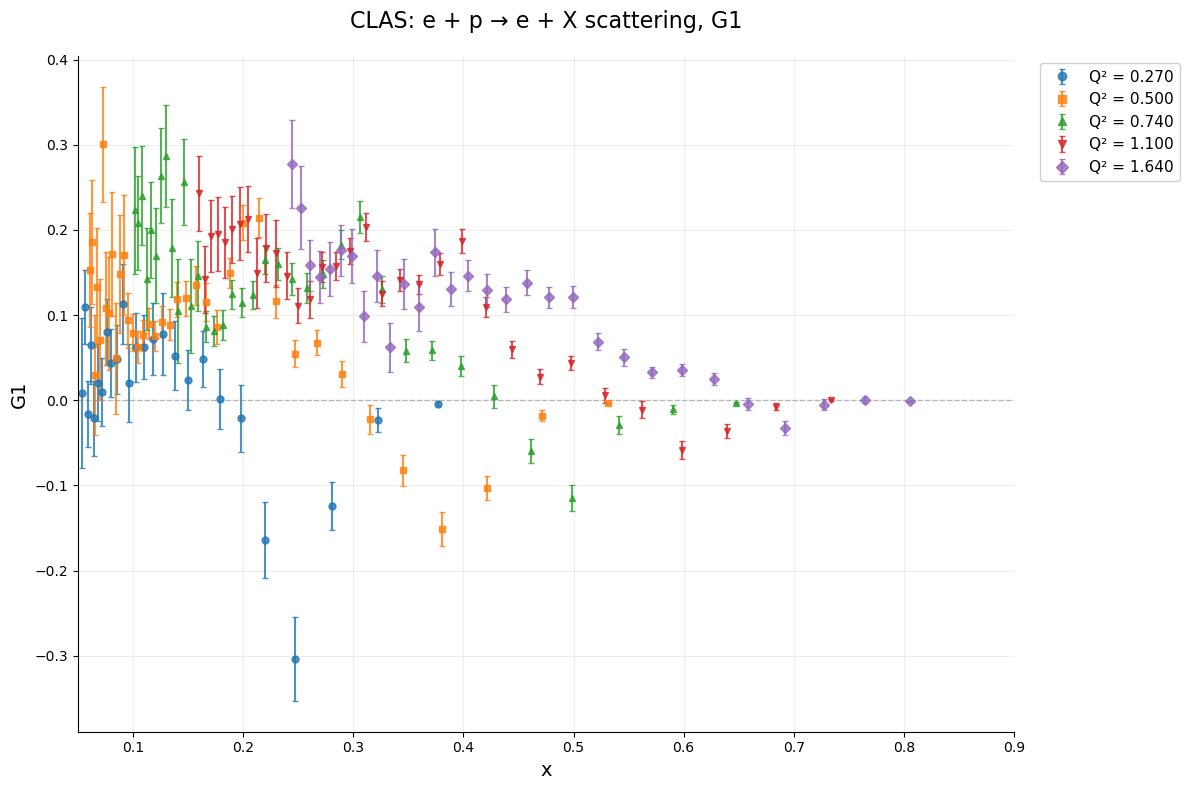

In [38]:
#Run the plot
if __name__ == "__main__":
    plot_clas_g1_data()